In [25]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
from matplotlib import rcParams
import matplotlib.colors as colors
import os
import glob
from scipy import io

from utils import *
import numpy as np       
import datetime as dt 

# Plotting preferences

rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 14}) 
rcParams['axes.titlepad'] = 14 
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'
myFmt = md.DateFormatter('%d')
rule = md.DayLocator(interval=1)

In [4]:
# Extract data

# Where are the raw .tar files?
dloc = '/Volumes/Data/ICECAPSarchive/ace/raw/'

# What data do you want to get?
dname = 'CLASP'

# Where do you want to store the extracted .tar files? 
extract_out = '/Volumes/Data/ICECAPSarchive/ace/Extracted/CLASP/'

# Extract all tar files. 
extract_tar(dloc,extract_out,dname)

In [33]:
extract_out = '/Volumes/Data/ICECAPSarchive/ace/Extracted/CLASP/'
# Get plot times
d2 = dt.datetime(2019,11,10)
d1 = dt.datetime(2019,10,16)

In [36]:
# Function to read and process CLASP data
# Inputs

def get_clasp(d_loc,d1,d2,claspn,channels,calfile,sf):
    # Function to convery interger to binary.
    get_bin = lambda x, n: format(x, 'b').zfill(n)
    os.chdir(d_loc)                  # Change directory to where the data is
    #log = open(log_licor,'w')             # Open the log file for writing
    all_files = glob.glob('*%s*'%claspn)
    file_dates = np.asarray([(dt.datetime.strptime(f[-14:-4], '%Y-%m-%d')).date() for f in all_files])
    idxs = np.where(np.logical_and(file_dates>=d1.date(), file_dates<=d2.date()))[0]
    dfs = [all_files[i] for i in idxs]
    data_block=[]
    for f in dfs: 
        # Read in the data
        fid = open(f)
        data_block.append(list(filter(('\n').__ne__, fid.readlines())))
        fid.close()
        
    data_block=list(np.concatenate(data_block))
     
    # Initialise empty dataframes
    dates = []
    CLASP = np.ones([np.shape(data_block)[0],16])*-999  # Counts
    statusaddr = np.ones(np.shape(data_block)[0])*-999  # Status address
    parameter = np.ones(np.shape(data_block)[0])*-999   # Parameter value
    overflow = np.ones(np.shape(data_block)[0])*-999    # Overflow (channel 1-8 only)
    #flow_check = np.ones(len(data_block))*-999  # True if flow is in range - this is too stringent, can ignore
    heater = np.ones(np.shape(data_block)[0])*-999      # True if heater is on
    #sync = np.ones(len(data_block))*-999       # CAN IGNORE THIS - it's not connected

    # Loop through, extract and sort data into the dataframes initialised above
    for i in range(0,np.shape(data_block)[0]):
        split = data_block[i].split()
        # Extract and store dates
        date = dt.datetime(int(split[0]),int(split[1]),int(split[2]),
                           int(split[3]),int(split[4]),
                           int(np.floor(float(split[5])))) 
        dates.append(date)   

        if len(split)!=25:
            continue
    
        # Extract and store counts
        for x in range(0,16):
            CLASP[i,x] = float(split[-16:][x])    
    
        # Extract, and convert staus addresses, store flags
        statusbyte=float(split[6])
        binary=get_bin(int(statusbyte),8)
        statusaddr[i] = int(binary[4:8],2)
        heater[i] = int(binary[2])       # check you have these the right way around
         
        # Extract and store status parameters and overflow flag
        parameter[i]=float(split[7])
        overflow[i]=float(split[8])  
      
        # Check overflow flags and correct histogram. 
        # Overflow is for channels 1 to 8 only.
        for n in range(0,8):
            obin=get_bin(int(overflow[i]),8)
            if int(obin[::-1][0]):
                #print('overfow recorded')
                CLASP[i,n] = CLASP[i,n] + 256
                
        # Arrange parameters into a neat dataframe
    param_len = int(len(statusaddr)/10)
    
    rejects = parameter[np.where(statusaddr==0)[0][0:param_len]]
    threshold = parameter[np.where(statusaddr==1)[0][0:param_len]]
    ThisFlow = parameter[np.where(statusaddr==2)[0][0:param_len]]
    FlowPWM = parameter[np.where(statusaddr==3)[0][0:param_len]]
    PumpCurrent = parameter[np.where(statusaddr==4)[0][0:param_len]]
    SensorT = parameter[np.where(statusaddr==5)[0][0:param_len]]
    HousingT = parameter[np.where(statusaddr==6)[0][0:param_len]]
    PumpT = parameter[np.where(statusaddr==7)[0][0:param_len]]
    SupplyV = parameter[np.where(statusaddr==8)[0][0:param_len]]
    LaserR  = parameter[np.where(statusaddr==9)[0][0:param_len]]
    param_dates = np.asarray(dates)[np.where(statusaddr==0)[0][0:param_len]]
   
    if len(param_dates)<param_len:
        param_len = len(param_dates)
    if len(rejects)<param_len:
        param_len = len(rejects)
    if len(threshold)<param_len:
        param_len = len(threshold)
    if len(ThisFlow)<param_len:
        param_len = len(ThisFlow)
    if len(FlowPWM)<param_len:
        param_len = len(FlowPWM)
    if len(PumpCurrent)<param_len:
        param_len = len(PumpCurrent)
    if len(SensorT)<param_len:
        param_len = len(SensorT)
    if len(HousingT)<param_len:
        param_len = len(HousingT)
    if len(PumpT)<param_len:
        param_len = len(PumpT)
    if len(SupplyV)<param_len:
        param_len = len(SupplyV)
    if len(LaserR)<param_len:
        param_len = len(LaserR)

    param_dates = np.asarray(dates)[np.where(statusaddr==0)[0][0:param_len]] 
    rejects = parameter[np.where(statusaddr==0)[0][0:param_len]]
    threshold = parameter[np.where(statusaddr==1)[0][0:param_len]]
    ThisFlow = parameter[np.where(statusaddr==2)[0][0:param_len]]
    FlowPWM = parameter[np.where(statusaddr==3)[0][0:param_len]]
    PumpCurrent = parameter[np.where(statusaddr==4)[0][0:param_len]]
    SensorT = parameter[np.where(statusaddr==5)[0][0:param_len]]
    HousingT = parameter[np.where(statusaddr==6)[0][0:param_len]]
    PumpT = parameter[np.where(statusaddr==7)[0][0:param_len]]
    SupplyV = parameter[np.where(statusaddr==8)[0][0:param_len]]
    LaserR  = parameter[np.where(statusaddr==9)[0][0:param_len]]

    param_df=pd.DataFrame({'Date':param_dates,'Rejects (n)':rejects,'Threshold (mV)':threshold,
                        'ThisFlow':ThisFlow,'FlowPWM':FlowPWM,'PumpCurrent (mA)':PumpCurrent,
                        'SensorT (C)':SensorT,'HousingT (C)':HousingT,'PumpT (C)':PumpT,
                        'SupplyV':SupplyV,'LaserR':LaserR})

    param_df = param_df.set_index('Date')
    param_df.index = pd.DatetimeIndex(param_df.index)
    param_df = param_df[~param_df.index.duplicated()]

    # Arrange Counts into a neat dataframe
    CLASP_df = pd.DataFrame({'Date':dates,
                        1:CLASP[:,0],2:CLASP[:,1],
                        3:CLASP[:,2],4:CLASP[:,3], 5:CLASP[:,4],
                        6:CLASP[:,5],7:CLASP[:,6],8:CLASP[:,7],9:CLASP[:,8],
                        10:CLASP[:,9],11:CLASP[:,10],12:CLASP[:,11], 
                        13:CLASP[:,12],14:CLASP[:,13],15:CLASP[:,14],16:CLASP[:,15]})
    CLASP_df = CLASP_df.set_index('Date')
    CLASP_df.index = pd.DatetimeIndex(CLASP_df.index)
    CLASP_df = CLASP_df[~CLASP_df.index.duplicated()]
    CLASP_df = pd.concat([CLASP_df, param_df], axis=1)

    # Apply flow corrections and quality flags, 
    # convert raw counts to concentrations in particles per ml.
    # Get calibration data
    cal_dict=io.loadmat(calfile,matlab_compatible=True)
    TSIflow = cal_dict['calibr'][0][0][8][0]         # array of calibration flow rates from TSI flow meter
    realflow = cal_dict['calibr'][0][0][9][0]        # array of measured A2D flow rates matching TSflow

    # Do flow correction and convert to concentations
    # TSI flow is from the TSI flowmeter, realflow is the flow the CLASP records internally
    P = np.polyfit(realflow,TSIflow,2) # These are from the flow calibration - fit a polynomial
    flow = np.polyval(P,CLASP_df['ThisFlow']) # flow in L/min
    flow_correction = ((flow/60)*1000)/sf # Sample volume in cm3/s

    # Interpolate flow correction onto full timeseries and add to array
    def nan_helper(y):
        return np.isnan(y), lambda z: z.nonzero()[0]
    nans, x= nan_helper(flow_correction)
    flow_correction[nans]= np.interp(x(nans), x(~nans), flow_correction[~nans])
    CLASP_df['Sample volume (ml/s)']=flow_correction
    

    # Now to plot concentrations in counts/cm3, just need to divide the counts/s by the sample volume
    clasp_counts = CLASP_df[CLASP_df.columns[0:16]]
    clasp_params = CLASP_df[CLASP_df.columns[16:]]
    clasp_counts = clasp_counts.apply(pd.to_numeric, errors='coerce')
    clasp_counts = clasp_counts.divide(flow_correction, axis=0)
    
    # CLASP-G flowrate = 3L/minute = 50 cm3/second
    # Units: particle counts/ sample interval
    # Sample interval: 1s
    # Calculate total counts
    # Calculate concentation
    
    #CLASP_df['Concentration (/cm3)'] = CLASP_df['total_counts'] / 50 #counts/cm3
    
    return clasp_counts,clasp_params

In [38]:
channels = 16 # Number of aerosol concentration channels (usually 16)
calfile = '/Users/heather/Desktop/Summit_May_2019/Instruments/CLASP/CLASP-cal-Feb2019/calibration-unit-F-Feb2019.mat' # Calibration .mat file
clasp_counts,clasp_params = get_clasp(extract_out,d1,d2,'CLASP_F',16,calfile,1)

# Calculate total c/cm3 for each dataset - just the sum of c/cm3 in individual bins
clasp_total = clasp_counts.sum(axis=1)

# For plots, resample everything to 10s by median?.
clasp_total_10 = clasp_total.resample('10s').median()
clasp_counts_10 = clasp_counts.resample('10s').median()

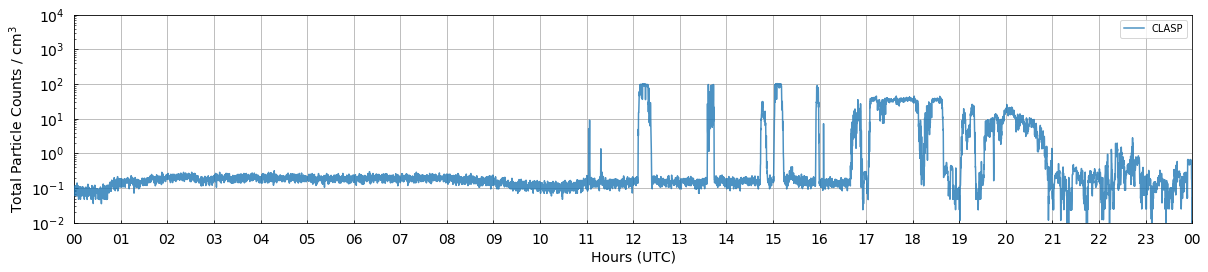

In [54]:
# Plot totals counts

fig = plt.figure(figsize=(17,4))
ax = fig.add_subplot(111)
ax.grid(True)
ax.semilogy(clasp_total_10.index,clasp_total_10,label = 'CLASP',zorder=5,alpha=0.8)
    
ax.set_ylim(0.01,10000)
ax.set_ylabel('Total Particle Counts / cm$^3$')
#ax.set_title('Total Particle Counts: %s'%((dt.datetime.strftime(dt.datetime(2019,10,22),'%Y-%m-%d')+' to '+dt.datetime.strftime(dt.datetime(2019,10,23),'%Y-%m-%d'))))
ax.set_xlabel('Hours (UTC)')
ax.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax.xaxis.set_major_locator(md.HourLocator(interval=1))
ax.set_xlim(dt.datetime(2019,10,22,0,0),dt.datetime(2019,10,23,0,0))
ax.legend(loc='best',fontsize=10)
fig.tight_layout()

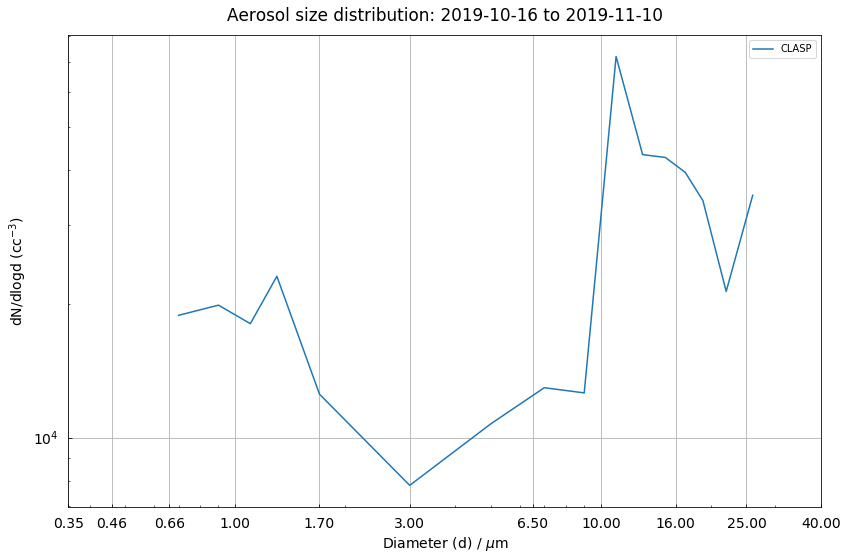

In [41]:
# Plot distribtuion

def plot_dist(dists,labels,xlims):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.grid(True)
    for i in range(0,len(dists)):
        if not dists[i]:
            continue
        else:
            ax.loglog(dists[i][0],dists[i][1],label=labels[i])

    ax.set_xlim(xlims[0],xlims[1])
    ax.set_xticks([0.35, 0.46, 0.66, 1, 1.7, 3,6.5,10, 16, 25, 40])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlabel('Diameter (d) / $\mu$m')
    ax.set_ylabel('dN/dlogd (cc$^{-3}$)')
    ax.legend(loc='best',fontsize=10)
    ax.set_title('Aerosol size distribution: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))
    fig.tight_layout()
    #fig.savefig(d_loc + 'Spectra_current.png')
    #fig.clf()

CLASP_bins=16
CLASP_bounds=[0.6,0.8,1,1.2,1.4,2,4,6,8,10,12,14,16,18,20,24,28]
CLASP_dist= get_dist(clasp_counts_10,CLASP_bins,CLASP_bounds)

plot_dist([CLASP_dist],['CLASP'],[CLASP_bounds[0],CLASP_bounds[-1]])


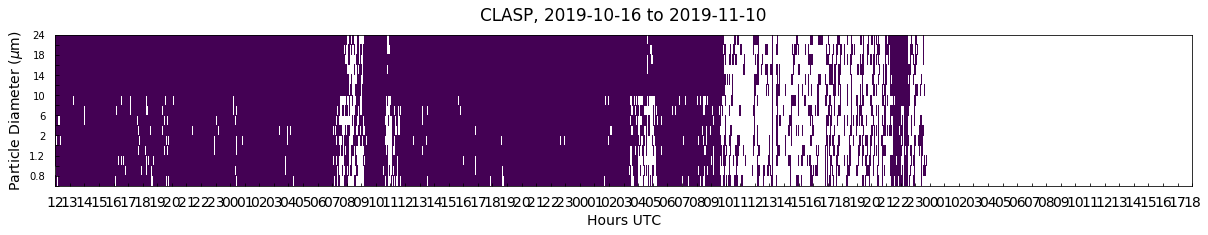

In [62]:
# Plot time series distribution

clasp_counts_np = clasp_counts_10.to_numpy()
clasp_dates = np.array(clasp_counts_10.index.to_pydatetime())
 
in_x = [clasp_dates]
in_y = [clasp_counts_np]
in_bounds = [CLASP_bounds]
in_names = ['CLASP']

nrow = len(in_x)
fig, axs = plt.subplots(nrows=nrow, ncols=1,squeeze=0,sharex=True,figsize=(17,3*nrow))
for i in range(0,nrow):
    x = in_x[i]
    y = in_y[i]
    bins=in_bounds[i]
    name = in_names[i]
    cs = axs[i][0].pcolormesh(x,np.arange(0,len(bins)-1,1),np.transpose(y),norm=colors.LogNorm(vmin=1, vmax=100),cmap='viridis')
    axs[i][0].xaxis_date()
    axs[i][0].set_title('%s, %s to %s'%(name,dt.datetime.strftime(d1,'%Y-%m-%d'),dt.datetime.strftime(d2,'%Y-%m-%d')))
    axs[i][0].set_yticks(np.arange(0,len(bins)-1,1))
    axs[i][0].tick_params(axis='y', which='major', labelsize=10) 
    for label in axs[i][0].yaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    axs[i][0].set_yticklabels(bins)
    axs[i][0].set_ylabel('Particle Diameter ($\mu$m)')
    if i==nrow-1:
        axs[i][0].set_xlabel('Hours UTC')
    #axs[i][0].set_xlim(d1,d2)
    #axs[i][0].xaxis.set_major_formatter(myFmt)
    #axs[i][0].xaxis.set_major_locator(rule)   
    
    axs[i][0].xaxis.set_major_formatter(md.DateFormatter('%H'))
    axs[i][0].xaxis.set_major_locator(md.HourLocator(interval=1))
    axs[i][0].set_xlim(dt.datetime(2019,11,7,12,0),dt.datetime(2019,11,10,18,0))

fig.tight_layout()    
fig.subplots_adjust(bottom=0.1)
#cbar_ax = fig.add_axes([0.2, 0.03, 0.7, 0.02])
#fig.colorbar(cs,extend='max',cax=cbar_ax,orientation='horizontal',label='Counts/cm3',pad=0.2)
#fig.savefig(d_loc + 'ace_timeseries_current.png')
#fig.clf()

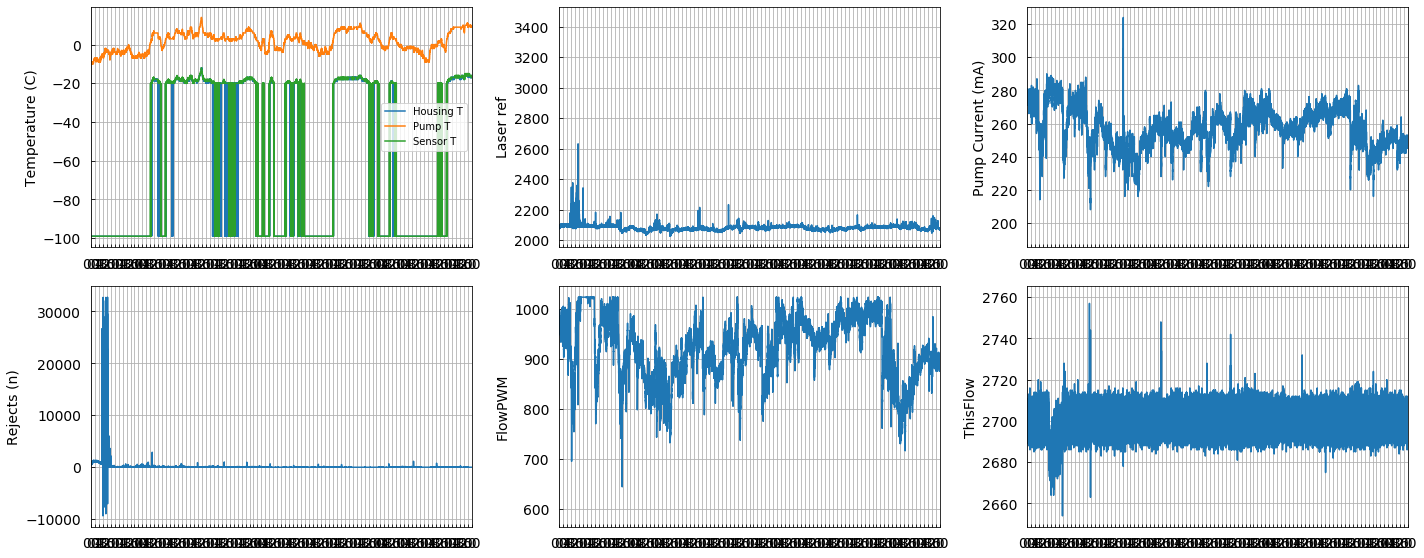

In [63]:
# Plot health parameters:

# Plot CLASP params. 
# FlowPWM, temperatures, LaserR, PumpCurrent, Rejects, This Flow
clasp_params = clasp_params.dropna()
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(231)
ax1.grid(True)
ax1.plot(clasp_params.index,clasp_params['HousingT (C)'],label='Housing T')
ax1.plot(clasp_params.index,clasp_params['PumpT (C)'],label='Pump T')
ax1.plot(clasp_params.index,clasp_params['SensorT (C)'],label='Sensor T')
ax1.set_ylabel('Temperature (C)')
ax1.legend(loc='best',fontsize=10)

ax1.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax1.xaxis.set_major_locator(md.HourLocator(interval=4))
ax1.set_xlim(dt.datetime(2019,10,22,0,0),dt.datetime(2019,11,7,0,0))

ax2 = fig.add_subplot(232)
ax2.grid(True)
ax2.plot(clasp_params.index,clasp_params['LaserR'])
ax2.set_ylabel('Laser ref')

ax2.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax2.xaxis.set_major_locator(md.HourLocator(interval=4))
ax2.set_xlim(dt.datetime(2019,10,22,0,0),dt.datetime(2019,11,7,0,0))


ax3 = fig.add_subplot(233)
ax3.grid(True)
ax3.plot(clasp_params.index,clasp_params['PumpCurrent (mA)'])
ax3.set_ylabel('Pump Current (mA)')

ax3.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax3.xaxis.set_major_locator(md.HourLocator(interval=4))
ax3.set_xlim(dt.datetime(2019,10,22,0,0),dt.datetime(2019,11,7,0,0))


ax4 = fig.add_subplot(234)
ax4.grid(True)
ax4.plot(clasp_params.index,clasp_params['Rejects (n)'])
ax4.set_ylabel('Rejects (n)')

ax4.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax4.xaxis.set_major_locator(md.HourLocator(interval=4))
ax4.set_xlim(dt.datetime(2019,10,22,0,0),dt.datetime(2019,11,7,0,0))

ax5 = fig.add_subplot(235)
ax5.grid(True)
ax5.plot(clasp_params.index,clasp_params['FlowPWM'])
ax5.set_ylabel('FlowPWM')

ax5.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax5.xaxis.set_major_locator(md.HourLocator(interval=4))
ax5.set_xlim(dt.datetime(2019,10,22,0,0),dt.datetime(2019,11,7,0,0))


ax6 = fig.add_subplot(236)
ax6.grid(True)
ax6.plot(clasp_params.index,clasp_params['ThisFlow'])
ax6.set_ylabel('ThisFlow')

ax6.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax6.xaxis.set_major_locator(md.HourLocator(interval=4))
ax6.set_xlim(dt.datetime(2019,10,22,0,0),dt.datetime(2019,11,7,0,0))

fig.tight_layout()

In [48]:
clasp_params

,Rejects (n),Threshold (mV),ThisFlow,FlowPWM,PumpCurrent (mA),SensorT (C),HousingT (C),PumpT (C),SupplyV,LaserR,Sample volume (ml/s)
Date,,,,,,,,,,,
2019-10-16 00:00:07,21.0,48.0,2707.0,921.0,258.0,-99.0,-99.0,3.0,1116.0,2065.0,43.026503
2019-10-16 00:00:17,32.0,48.0,2697.0,923.0,259.0,-20.0,-99.0,3.0,1128.0,2065.0,41.547949
2019-10-16 00:00:27,25.0,48.0,2704.0,922.0,259.0,-20.0,-99.0,3.0,1120.0,2070.0,42.583263
2019-10-16 00:00:37,18.0,48.0,2695.0,924.0,259.0,-20.0,-99.0,3.0,1128.0,2064.0,41.251865
2019-10-16 00:00:47,29.0,48.0,2709.0,926.0,260.0,-20.0,-99.0,3.0,1120.0,2065.0,43.321841
...,...,...,...,...,...,...,...,...,...,...,...
2019-11-09 23:59:14,2.0,48.0,2698.0,716.0,226.0,-99.0,-99.0,-3.0,1136.0,2087.0,41.695944
2019-11-09 23:59:24,1.0,48.0,2709.0,717.0,227.0,-99.0,-99.0,-3.0,1136.0,2083.0,43.321841
2019-11-09 23:59:34,2.0,48.0,2701.0,716.0,227.0,-99.0,-99.0,-3.0,1136.0,2089.0,42.139744
